In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

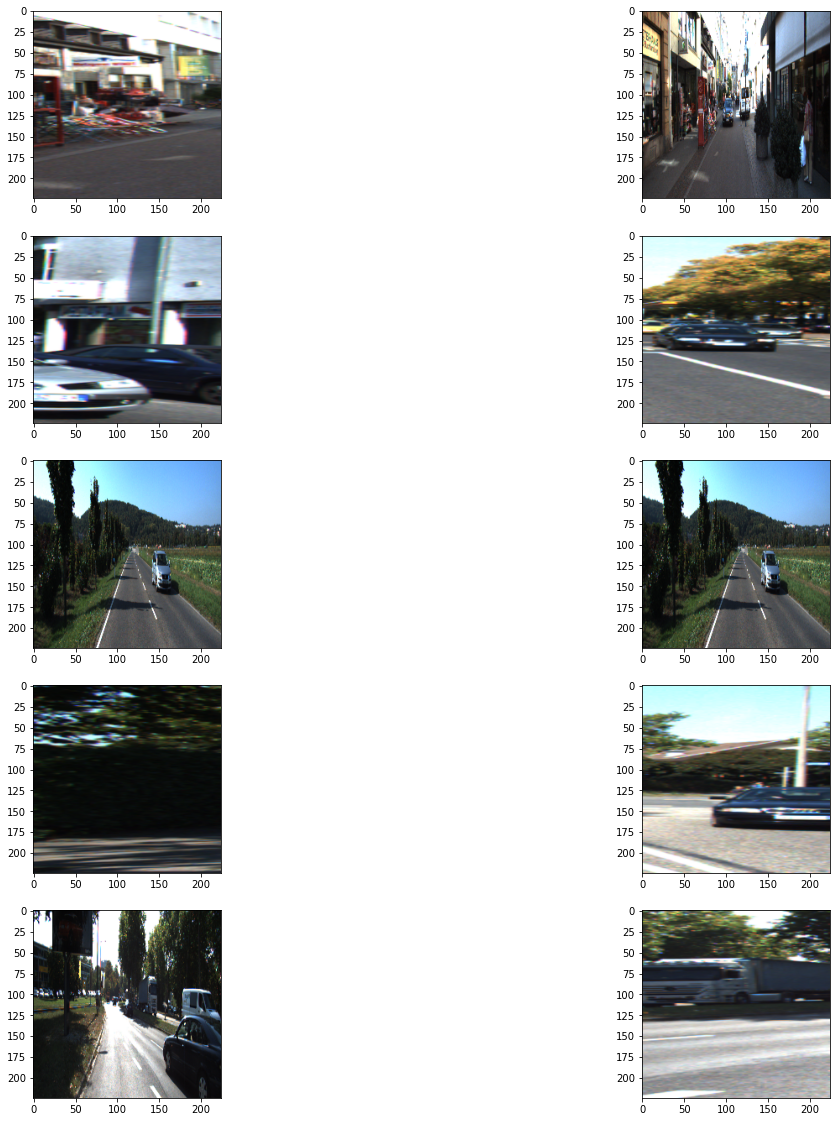

In [4]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(20, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [14]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                    "image": _input,
                    "mask": _output,
                   }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

In [15]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net

In [67]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [68]:
model = build_model()
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_500 (Conv2D)             (None, 224, 224, 64) 1792        input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_501 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_500[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_64 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_501[0][0]                 
___________________________________________________________________________________________

In [18]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 27s 674ms/step - loss: 0.7139 - val_loss: 0.5522
Epoch 2/100
11/11 [==============================] - 7s 632ms/step - loss: 0.4512 - val_loss: 0.4374
Epoch 3/100
11/11 [==============================] - 7s 624ms/step - loss: 0.3776 - val_loss: 0.3810
Epoch 4/100
11/11 [==============================] - 7s 622ms/step - loss: 0.3253 - val_loss: 0.3262
Epoch 5/100
11/11 [==============================] - 7s 628ms/step - loss: 0.2735 - val_loss: 0.3682
Epoch 6/100
11/11 [==============================] - 7s 650ms/step - loss: 0.2910 - val_loss: 0.3368
Epoch 7/100
11/11 [==============================] - 7s 632ms/step - loss: 0.2683 - val_loss: 0.3212
Epoch 8/100
11/11 [==============================] - 7s 631ms/step - loss: 0.2188 - val_loss: 0.2702
Epoch 9/100
11/11 [==============================] - 7s 632ms/step - loss: 0.2062 - val_loss: 0.3301
Epoch 10/100
11/11 [==============================] - 7s 633ms/step - loss: 0.2282 - val_l

In [41]:
model = load_model(dir_path + '/seg_model_unet.h5')

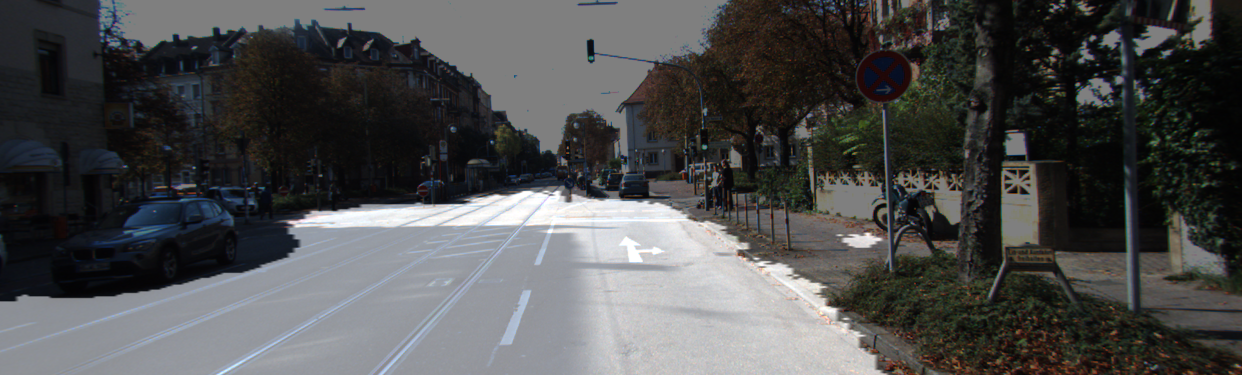

In [42]:
def get_output(model, preproc, image_path, output_path):
    # image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화
    # 이를 output_path에 저장하는 함수.
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 시각화한 결과를 눈으로 확인!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### IoU(Intersection over Union)

In [5]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [6]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [55]:
for i in range(5):
    output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    calculate_iou_score(target, prediction)

IoU : 0.885378
IoU : 0.911429
IoU : 0.745365
IoU : 0.723743
IoU : 0.885003


# U-Net++

In [7]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=2,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                    "image": _input,
                    "mask": _output,
                   }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [11]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    drop1 = Dropout(0.5)(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    drop2 = Dropout(0.5)(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    up1_2 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1)) 
    merge1_2 = concatenate([up1_2,conv1_1], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
        
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)
    drop3 = Dropout(0.5)(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    up2_2 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1)) 
    merge2_2 = concatenate([up2_2,conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    
    up1_3 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2)) 
    merge1_3 = concatenate([up1_3,conv1_1,conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_1)
    drop4 = Dropout(0.5)(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    up3_2 = Conv2DTranspose(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_1)) 
    merge3_2 = concatenate([up3_2, conv3_1], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_2)
    
    up2_3 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_2)) 
    merge2_3 = concatenate([up2_3, conv2_1, conv2_2], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_3)
    
    up1_4 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_3)) 
    merge1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_4)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_4)
        
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5_1)

    up4_2 = Conv2DTranspose(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5_1)) 
    merge4_2 = concatenate([up4_2, conv4_1], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_2)
    
    up3_3 = Conv2DTranspose(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_2)) 
    merge3_3 = concatenate([up3_3, conv3_1, conv3_2], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_3)

    up2_4 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_3)) 
    merge2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_4)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_4)
    
    up1_5 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_4)) 
    merge1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_5)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_5)
     
    conv0 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_5)
    output = Conv2D(1, 1, activation='sigmoid')(conv0)
    model = Model(inputs=inputs, outputs=output)
    
#     output1 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_2)
#     output2 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_3)
#     output3 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_4)
#     output4 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv1_5)
    
    # outputs = tf.keras.layers.Average()([output1, output2, output3, output4])
    # model = Model(inputs = inputs, outputs = [output1, output2, output3, output4])
    return model

## 5/1 수정

In [9]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
    drop1 = Dropout(0.5)(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
    drop2 = Dropout(0.5)(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    up1_2 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1)) 
    merge1_2 = concatenate([up1_2,conv1_1], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
        
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)
    drop3 = Dropout(0.5)(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    up2_2 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1)) 
    merge2_2 = concatenate([up2_2,conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    
    up1_3 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2)) 
    merge1_3 = concatenate([up1_3,conv1_1,conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
    
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_1)
    drop4 = Dropout(0.5)(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    up3_2 = Conv2DTranspose(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_1)) 
    merge3_2 = concatenate([up3_2, conv3_1], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_2)
    
    up2_3 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_2)) 
    merge2_3 = concatenate([up2_3, conv2_1, conv2_2], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_3)
    
    up1_4 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_3)) 
    merge1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_4)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_4)
        
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5_1)

    up4_2 = Conv2DTranspose(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5_1)) 
    merge4_2 = concatenate([up4_2, conv4_1], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_2)
    
    up3_3 = Conv2DTranspose(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4_2)) 
    merge3_3 = concatenate([up3_3, conv3_1, conv3_2], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_3)

    up2_4 = Conv2DTranspose(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_3)) 
    merge2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_4)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_4)
    
    up1_5 = Conv2DTranspose(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_4)) 
    merge1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_5)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_5)
    
    output1 = Conv2D(1, 1, activation='sigmoid')(conv1_2)
    output2 = Conv2D(1, 1, activation='sigmoid')(conv1_3)
    output3 = Conv2D(1, 1, activation='sigmoid')(conv1_4)
    output4 = Conv2D(1, 1, activation='sigmoid')(conv1_5)
    
    outputs = tf.keras.layers.Average()([output1, output2, output3, output4])
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet++_last.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
85/85 [==============================] - 22s 233ms/step - loss: 0.1528 - val_loss: 0.2168
Epoch 2/100
85/85 [==============================] - 19s 227ms/step - loss: 0.1631 - val_loss: 0.2243
Epoch 3/100
85/85 [==============================] - 19s 227ms/step - loss: 0.1507 - val_loss: 0.2188
Epoch 4/100
85/85 [==============================] - 20s 230ms/step - loss: 0.1438 - val_loss: 0.2392
Epoch 5/100
85/85 [==============================] - 20s 230ms/step - loss: 0.1540 - val_loss: 0.2549
Epoch 6/100
85/85 [==============================] - 20s 236ms/step - loss: 0.2226 - val_loss: 0.2450
Epoch 7/100
85/85 [==============================] - 19s 228ms/step - loss: 0.1752 - val_loss: 0.2252
Epoch 8/100
85/85 [==============================] - 21s 241ms/step - loss: 0.1529 - val_loss: 0.2387
Epoch 9/100
85/85 [==============================] - 21s 242ms/step - loss: 0.1721 - val_loss: 0.2290
Epoch 10/100
85/85 [==============================] - 21s 241ms/step - loss: 0.166

85/85 [==============================] - 21s 244ms/step - loss: 0.1521 - val_loss: 0.2977
Epoch 81/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1945 - val_loss: 0.2457
Epoch 82/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1598 - val_loss: 0.2139
Epoch 83/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1532 - val_loss: 0.2447
Epoch 84/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1319 - val_loss: 0.2391
Epoch 85/100
85/85 [==============================] - 21s 243ms/step - loss: 0.1398 - val_loss: 0.2421
Epoch 86/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1476 - val_loss: 0.1988
Epoch 87/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1273 - val_loss: 0.2945
Epoch 88/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1373 - val_loss: 0.2079
Epoch 89/100
85/85 [==============================] - 21s 244ms/step - loss: 0.1310 - 

In [13]:
model = load_model(dir_path + '/seg_model_unet++_last.h5')

In [19]:
for i in range(5):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    calculate_iou_score(target, prediction)

IoU : 0.937130
IoU : 0.944899
IoU : 0.808315
IoU : 0.832836
IoU : 0.807851


In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
#     output = Image.fromarray(output)
#     background = Image.fromarray(origin_img).convert('RGBA')
#     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
#     output = Image.blend(background, output, alpha=0.5)
#     output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [59]:
model_unet = load_model(dir_path + '/seg_model_unet.h5')
model_nestedunet = load_model(dir_path + '/seg_model_unet++.h5')

In [31]:
unetIoU = []
for i in range(200):
    output, prediction, target = get_output(
         model_unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    unetIoU.append(calculate_iou_score(target, prediction))

IoU : 0.885378
IoU : 0.911429
IoU : 0.745365
IoU : 0.723743
IoU : 0.885003
IoU : 0.771862
IoU : 0.804965
IoU : 0.891065
IoU : 0.894545
IoU : 0.835136
IoU : 0.851629
IoU : 0.854924
IoU : 0.798769
IoU : 0.876489
IoU : 0.902085
IoU : 0.895420
IoU : 0.896374
IoU : 0.880521
IoU : 0.852204
IoU : 0.903944
IoU : 0.799497
IoU : 0.811674
IoU : 0.926782
IoU : 0.858783
IoU : 0.825365
IoU : 0.875265
IoU : 0.613840
IoU : 0.874230
IoU : 0.897515
IoU : 0.853668
IoU : 0.845912
IoU : 0.854300
IoU : 0.857244
IoU : 0.806428
IoU : 0.885909
IoU : 0.941076
IoU : 0.889100
IoU : 0.902304
IoU : 0.892130
IoU : 0.891266
IoU : 0.892865
IoU : 0.908111
IoU : 0.909129
IoU : 0.895157
IoU : 0.902874
IoU : 0.910549
IoU : 0.892091
IoU : 0.884832
IoU : 0.893791
IoU : 0.836837
IoU : 0.884526
IoU : 0.890690
IoU : 0.903722
IoU : 0.901753
IoU : 0.874711
IoU : 0.819968
IoU : 0.861272
IoU : 0.881777
IoU : 0.870779
IoU : 0.887394
IoU : 0.910058
IoU : 0.927562
IoU : 0.948863
IoU : 0.963409
IoU : 0.878919
IoU : 0.934958
IoU : 0.89

In [60]:
nestIoU = []
for i in range(200):
    output, prediction, target = get_output(
         model_nestedunet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    nestIoU.append(calculate_iou_score(target, prediction))

IoU : 0.960387
IoU : 0.961977
IoU : 0.857198
IoU : 0.874979
IoU : 0.909416
IoU : 0.921592
IoU : 0.936148
IoU : 0.961745
IoU : 0.938085
IoU : 0.909408
IoU : 0.903628
IoU : 0.940771
IoU : 0.918123
IoU : 0.944343
IoU : 0.919221
IoU : 0.912144
IoU : 0.920112
IoU : 0.938154
IoU : 0.931208
IoU : 0.947032
IoU : 0.903383
IoU : 0.886314
IoU : 0.956243
IoU : 0.898298
IoU : 0.906126
IoU : 0.921795
IoU : 0.879663
IoU : 0.928426
IoU : 0.940153
IoU : 0.935212
IoU : 0.909427
IoU : 0.908860
IoU : 0.925048
IoU : 0.930190
IoU : 0.876994
IoU : 0.952722
IoU : 0.951161
IoU : 0.931805
IoU : 0.944103
IoU : 0.947781
IoU : 0.939460
IoU : 0.956908
IoU : 0.951746
IoU : 0.964820
IoU : 0.954157
IoU : 0.960367
IoU : 0.956115
IoU : 0.957436
IoU : 0.949913
IoU : 0.940330
IoU : 0.950607
IoU : 0.953087
IoU : 0.963737
IoU : 0.964871
IoU : 0.953907
IoU : 0.926865
IoU : 0.956169
IoU : 0.906213
IoU : 0.826379
IoU : 0.893537
IoU : 0.928145
IoU : 0.953639
IoU : 0.980499
IoU : 0.966549
IoU : 0.905390
IoU : 0.958350
IoU : 0.96

# Unet vs. Unet++

### 200개의 데이터 평균을 낸 결과 0.85와 0.91로 Unet++의 성능이 조금 더 좋은 것으로 보인다.
##### (근데, 생각보다 그냥 Unet 모델의 성능도 너무 좋은거 같은데.. 왜지?)

### 그리고 한가지 더 의문사항.. 4개의 output을 평균낸 Unet++ 컨셉보다 마지막 output만 가지고 학습시킨 것이 정확도가 더 높다.. Average layer 적용한 모델의 경우 평균 정확도가 0.86정도로 나옴

In [61]:
# 두 모델의 평균 IoU 비교
print("Unet average IoU: ", sum(unetIoU) / len(unetIoU))
print("Unet++ average IoU : ", sum(nestIoU) / len(nestIoU))

Unet average IoU:  0.8541930247390898
Unet++ average IoU :  0.9112247848256985


In [20]:
model_unet_average = load_model(dir_path + '/seg_model_unet++_last.h5')

In [21]:
nestIoU_avg = []
for i in range(200):
    output, prediction, target = get_output(
         model_unet_average, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
    nestIoU_avg.append(calculate_iou_score(target, prediction))

IoU : 0.937130
IoU : 0.944899
IoU : 0.808315
IoU : 0.832836
IoU : 0.807851
IoU : 0.741301
IoU : 0.881954
IoU : 0.916217
IoU : 0.881425
IoU : 0.877559
IoU : 0.867151
IoU : 0.874474
IoU : 0.829042
IoU : 0.918848
IoU : 0.911729
IoU : 0.909547
IoU : 0.911636
IoU : 0.922302
IoU : 0.901287
IoU : 0.911092
IoU : 0.883411
IoU : 0.751631
IoU : 0.908123
IoU : 0.892163
IoU : 0.828111
IoU : 0.768588
IoU : 0.646758
IoU : 0.909091
IoU : 0.936910
IoU : 0.856685
IoU : 0.869475
IoU : 0.869133
IoU : 0.918521
IoU : 0.916715
IoU : 0.691413
IoU : 0.949955
IoU : 0.935637
IoU : 0.927783
IoU : 0.919401
IoU : 0.937481
IoU : 0.931778
IoU : 0.941822
IoU : 0.925119
IoU : 0.933855
IoU : 0.924620
IoU : 0.935848
IoU : 0.921276
IoU : 0.923469
IoU : 0.914705
IoU : 0.887255
IoU : 0.907632
IoU : 0.904236
IoU : 0.926093
IoU : 0.935059
IoU : 0.952813
IoU : 0.898972
IoU : 0.949343
IoU : 0.857479
IoU : 0.868685
IoU : 0.900809
IoU : 0.934394
IoU : 0.958078
IoU : 0.976972
IoU : 0.974377
IoU : 0.920622
IoU : 0.950052
IoU : 0.96

In [22]:
print("Unet++ average layer IoU : ", sum(nestIoU_avg) / len(nestIoU_avg))

Unet++ average layer IoU :  0.8665344687254258
